In [14]:
# Importing required libraries
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
datasetpath = '/content/drive/MyDrive/dataset-resized'

In [5]:
# List dataset folders
print("Folders in Dataset path :")
print(os.listdir(datasetpath))

Folders in Dataset path :
['trash', 'plastic', 'metal', 'paper', 'cardboard', 'glass']


In [6]:
classes = ['cardboard', 'trash', 'paper', 'plastic', 'metal', 'glass']

/tmp/ipython-input-4093644658.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(classcounts.keys()), y=list(classcounts.values()), palette="viridis")


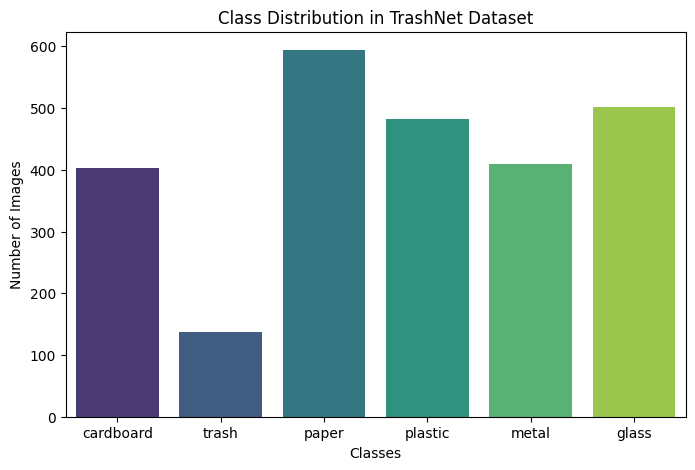

In [7]:
# Count images per class
classcounts = {cls: len(os.listdir(os.path.join(datasetpath,cls))) for cls in classes}
plt.figure(figsize=(8,5))
sns.barplot(x=list(classcounts.keys()), y=list(classcounts.values()), palette="viridis")
plt.title("Class Distribution in TrashNet Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

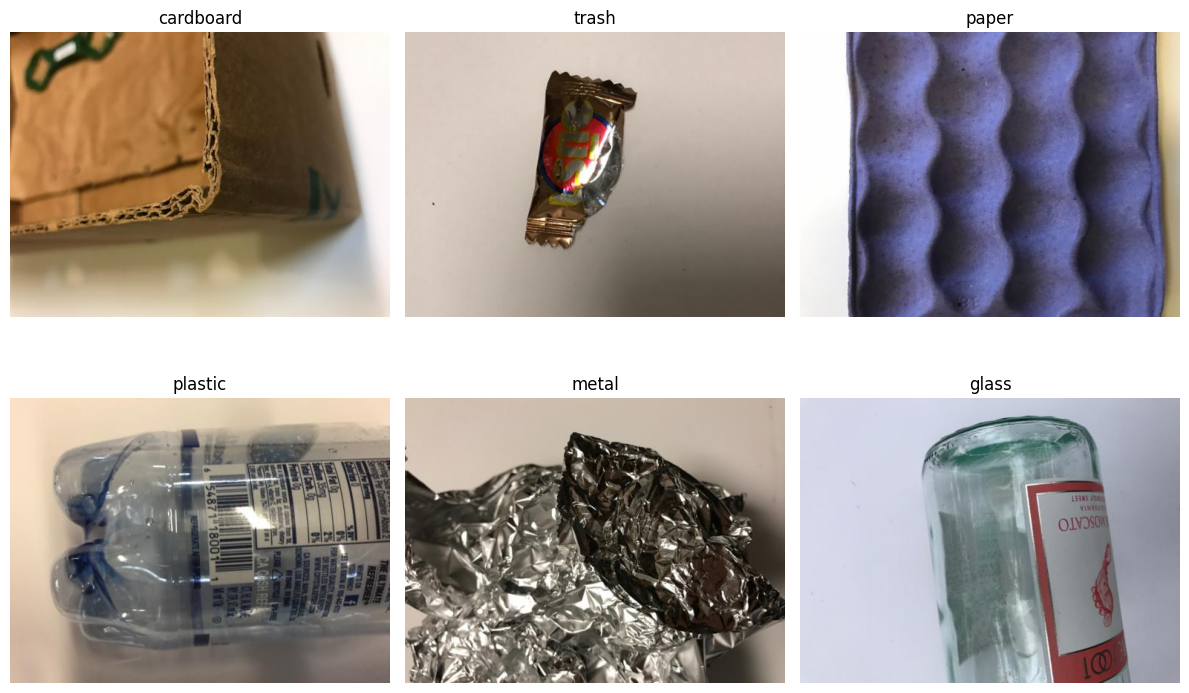

In [8]:
# Show sample images from each class
plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
  imgpath = os.path.join(datasetpath,cls,os.listdir(os.path.join(datasetpath,cls))[0])
  img = Image.open(imgpath)
  plt.subplot(2,3,i+1)
  plt.imshow(img)
  plt.title(cls)
  plt.axis('off')
plt.tight_layout()
plt.show()

Average Image Width: 512.00
Average Image Height: 384.00
{512}
{384}


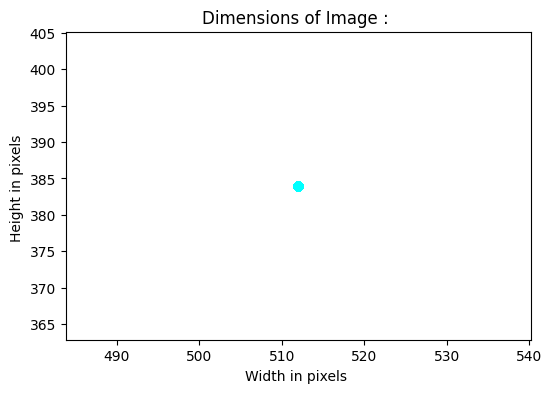

In [9]:
# Check image dimensions
imgshapes = []
for cls in classes:
    FOLDER = os.path.join(datasetpath, cls)
    for imgname in os.listdir(FOLDER):
        imgpath = os.path.join(FOLDER, imgname)
        img = Image.open(imgpath)
        imgshapes.append(img.size)

width, height = zip(*imgshapes)
print(f"Average Image Width: {np.mean(width):.2f}")
print(f"Average Image Height: {np.mean(height):.2f}")

print(set(width))
print(set(height))

plt.figure(figsize=(6, 4))
plt.scatter(width, height, alpha=0.7, color='cyan')
plt.title("Dimensions of Image : ")
plt.xlabel("Width in pixels ")
plt.ylabel("Height in pixels ")
plt.show()



In [10]:
# Analyze color distributions
meancolors = {cls: [] for cls in classes}

for cls in classes:
    FOLDER = os.path.join(datasetpath, cls)
    for imgname in os.listdir(FOLDER)[:50]:
        imgpath = os.path.join(FOLDER, imgname)
        img = cv2.imread(imgpath)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            meancolors[cls].append(np.mean(img, axis=(0, 1)))

meanrgb = {cls: np.mean(meancolors[cls], axis=0) for cls in classes}

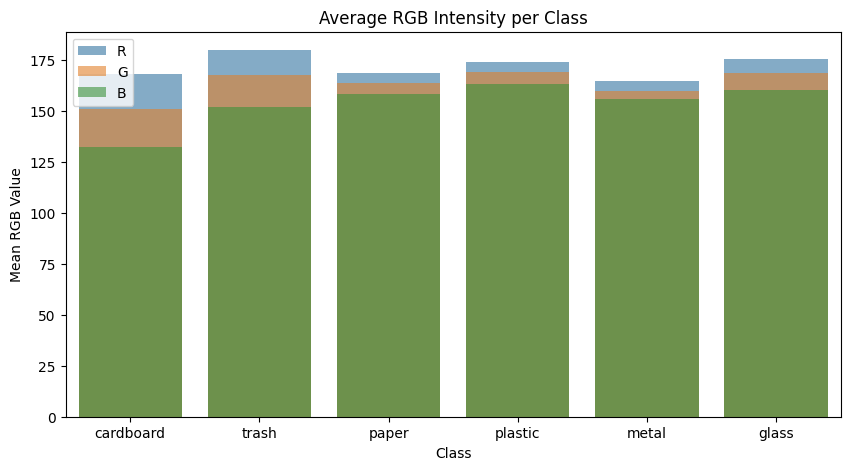

In [11]:
rgbdataframe = (
    sns.load_dataset("penguins")
    .iloc[:len(classes)]
    .copy()
)
rgbdataframe["Class"] = list(meanrgb.keys())
rgbdataframe["R"] = [v[0] for v in meanrgb.values()]
rgbdataframe["G"] = [v[1] for v in meanrgb.values()]
rgbdataframe["B"] = [v[2] for v in meanrgb.values()]

plt.figure(figsize=(10, 5))
for color in ["R", "G", "B"]:
    sns.barplot(x="Class", y=color, data=rgbdataframe, label=color, alpha=0.6)
plt.title("Average RGB Intensity per Class")
plt.xlabel("Class")
plt.ylabel("Mean RGB Value")
plt.legend()
plt.show()

In [12]:
print("\n Summary of EDA :")
print(f"Total no of Images: {sum(classcounts.values())}")
for cls, count in classcounts.items():
    print(f" - {cls}: {count} images")
print(f"Image Size Range: Width({min(width)}–{max(width)}), Height({min(height)}–{max(height)})")


 Summary of EDA :
Total no of Images: 2527
 - cardboard: 403 images
 - trash: 137 images
 - paper: 594 images
 - plastic: 482 images
 - metal: 410 images
 - glass: 501 images
Image Size Range: Width(512–512), Height(384–384)


In [15]:
# Setup augmentation for minority classes
input_folder = '/content/drive/MyDrive/dataset-resized'
output_folder = '/content/drive/MyDrive/dataset-augmented'
os.makedirs(output_folder, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05]
)

# Define how many new images per class
augmentation_counts = {
    'trash': 160,
    'cardboard': 80,
    'paper': 90,
    'plastic': 70,
    'metal': 70,
    'glass': 70
}

created_counts = {}

# Generate augmented images
for cls, n_aug in augmentation_counts.items():
    input_cls_path = os.path.join(input_folder, cls)
    output_cls_path = os.path.join(output_folder, cls)
    os.makedirs(output_cls_path, exist_ok=True)

    images = os.listdir(input_cls_path)
    num_of_images = len(images)
    aug_per_image = max(1, n_aug // num_of_images)
    created = 0

    for img in images:
        if created >= n_aug:
            break
        img_path = os.path.join(input_cls_path, img)
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img).reshape((1,) + img_to_array(img).shape)

        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_cls_path,
                                  save_prefix='aug', save_format='jpg'):
            created += 1
            if created >= n_aug:
                break

    created_counts[cls] = created

print("Augmentation Completed.")
total_augmented = sum(created_counts.values())
for cls, count in created_counts.items():
    print(f"{cls}: {count} augmented images")
print(f"\nTotal augmented images: {total_augmented}")

Augmentation Completed.
trash: 160 augmented images
cardboard: 80 augmented images
paper: 90 augmented images
plastic: 70 augmented images
metal: 70 augmented images
glass: 70 augmented images

Total augmented images: 540


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

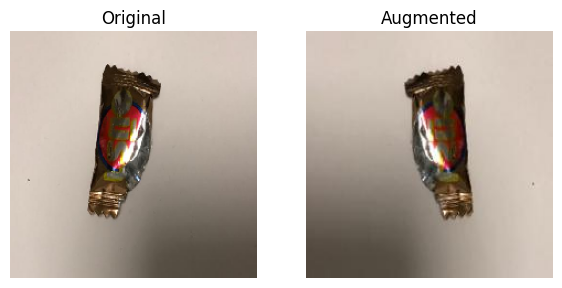

In [16]:
sample_cls = 'trash'
sample_cls_path = os.path.join(input_folder, sample_cls)
aug_cls_path = os.path.join(output_folder, sample_cls)

original_img_path = os.path.join(sample_cls_path, os.listdir(sample_cls_path)[0])
augmented_img_path = os.path.join(aug_cls_path, os.listdir(aug_cls_path)[0])

original_img = load_img(original_img_path, target_size=(224, 224))
augmented_img = load_img(augmented_img_path, target_size=(224, 224))

plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(augmented_img)
plt.title('Augmented')
plt.axis('off')

In [ ]:
# Merge original + augmented data
input_folder = '/content/drive/MyDrive/dataset-resized'
output_folder = '/content/drive/MyDrive/dataset-augmented'
final_dataset_dir = '/content/drive/MyDrive/dataset-final'
os.makedirs(final_dataset_dir, exist_ok=True)

for cls in os.listdir(input_folder):
    final_cls_path = os.path.join(final_dataset_dir, cls)
    os.makedirs(final_cls_path, exist_ok=True)

    for img in os.listdir(os.path.join(input_folder, cls)):
        src = os.path.join(input_folder, cls, img)
        dst = os.path.join(final_cls_path, img)
        shutil.copy(src, dst)

    for img in os.listdir(os.path.join(output_folder, cls)):
        src = os.path.join(output_folder, cls, img)
        dst = os.path.join(final_cls_path, img)
        shutil.copy(src, dst)

print("Merging of augmented dataset with original dataset complete!\n")

total_images = 0
class_counts = {}
image_shapes = []

for cls in os.listdir(final_dataset_dir):
    class_path = os.path.join(final_dataset_dir, cls)
    count = len(os.listdir(class_path))
    class_counts[cls] = count
    total_images += count

    first_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = load_img(first_img_path)
    image_shapes.append(np.array(img).shape)

print("No. of images in each class after merging with augmented images:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

print(f"\nTotal images in the entire dataset: {total_images}")

unique_shapes = set(image_shapes)
print(f"\nUnique image shapes: {unique_shapes}")

avg_images = total_images / len(class_counts)
print(f"\nAverage images per class: {avg_images:.1f}")


Merging of augmented dataset with original dataset complete!

No. of images in each class after merging with augmented images:
trash: 295 images
plastic: 551 images
metal: 479 images
paper: 684 images
cardboard: 483 images
glass: 571 images

Total images in the entire dataset: 3063

Unique image shapes: {(384, 512, 3)}

Average images per class: 510.5
